In [1]:
# prequisites
#uproot High energy physics python file format => https://masonproffitt.github.io/uproot-tutorial/aio.html
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
#plotting style for High Energy physics 
import lmfit as lm
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
#Now lets look at the data. Our data sample is the JetHT dataset. 
#What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data   = uproot.open("data/JetHT_s.root")["Tree"]
#In addition to above we have Monte Carlo Simulation of many processes
#Some of these process are well modelled in simulation and some of them are not
#Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq    = uproot.open("data/WQQ_s.root")["Tree"]
#Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq    = uproot.open("data/ZQQ_s.root")["Tree"]
#Unfortunately the samples I made above a long time ago are very small. 
#To train NNs and make nice plots we will use larger samples produced at a different collision energy
#qq=>W=>qq at 13TeV collision energy
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
#qq=>Z=>qq at 13TeV collision energy
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]
#Now we have our worst modeled background this is also our main background. 
#This is is our di-jet quark and gluon background. 
#We just call these backgrounds QCD because they are produced with Quantum chromo dynamics. 
qcd    = uproot.open("data/QCD_s.root")["Tree"]
#Now we have the Higgs boson sample (we might need this in the future)
ggh    = uproot.open("data/ggH.root")["Tree"]
#And top-quark pair production background. 
tt     = uproot.open("data/TT.root")["Tree"]
#Finally we have the rarer double W, W+Z and Z+Z diboson samples where we have two bosons instead of one
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]

In [3]:
def selection(iData):
        #lets apply a trigger selection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
        #Lets apply both jetpt and trigger at the same time
        #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
        allcuts = np.logical_and.reduce([trigger,jetpt])
        return allcuts
def get_weights(iData,weights,sel):
    weight = weights[0]
    for i in range(1,len(weights)):
        weight *= iData.arrays(weights[i],library="np")[weights[i]][sel]
    return weight

In [4]:
#This computs the integral of weighted events assuming a selection given by the function selection(see below)
def integral(iData,iWeights):
    #perform a selection on the data (
    mask_sel=selection(iData)
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    for i0 in range(1,len(iWeights)):
        weightarr = iData.arrays(iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        #multiply the weights
        weight    = weight*weightarr
    #now take the integral and return it
    return np.sum(weight)

#This computes the integral of two selections for two datasets labelled 8TeV and 13TeV, but really can be 1 and 2
#Then it returns the ratio of the integrals
def scale(iData8TeV,iData13TeV,iWeights):
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    return int_8TeV/int_13TeV

# Z fit

In [5]:
# Let's define a selection that will keep Z jets and remove background.
def selectiont21(iData):
        #lets apply a trigger selection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
        # Following the same procedure as https://arxiv.org/pdf/1603.00027.pdf
        # we select 2 progned jets (since W and Z primarily decay to 2 quarks)
        # we correct t21 to minimize the dependance on m and pt
        rho = np.log(iData.arrays('vjet0_msd0',library="np")["vjet0_msd0"]**2/iData.arrays('vjet0_pt',library="np")["vjet0_pt"])
        t21 = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"]/
               iData.arrays('vjet0_t1', library="np")["vjet0_t1"])
        t21ddt=t21+.05*rho
        t21cut   = t21ddt < .62
        # this cut keeps jets with subjet 1 and subjet 2 coming from a secondary vertex
        # i.e. the subjets originate from a displaced particle (namely a b quark)
        # Unlike W bosons, the Z can decay into 2 b quarks which is why this selection removes 
        # many W jets.
        ddb=iData.arrays("vjet0_sj1_csv", library="np")["vjet0_sj1_csv"]+iData.arrays("vjet0_sj2_csv", library="np")["vjet0_sj2_csv"]
        ddbcut = ddb >= 1.85
        allcuts = np.logical_and.reduce([trigger,jetpt, t21cut, ddbcut])
        return allcuts

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


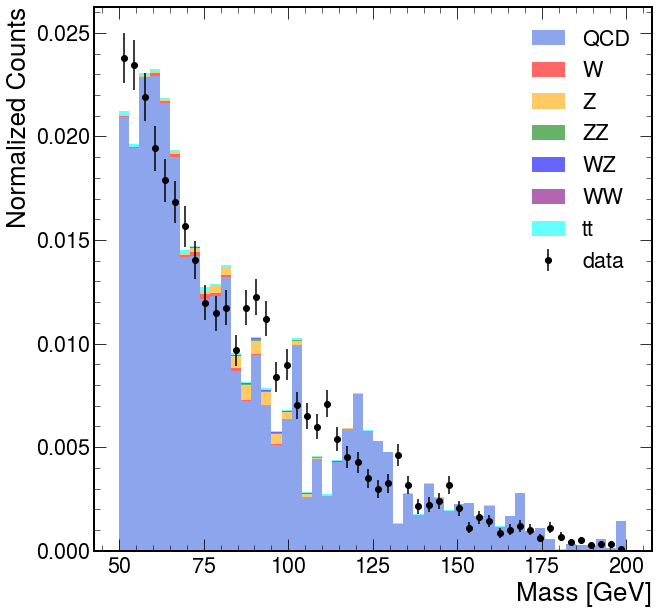

In [6]:
weights=[1000*18300,"puweight","scale1fb"]
mrange = (50,200) #range for mass histogram [GeV]
bins=50           #bins for mass histogram
density = True    #to plot the histograms as a density (integral=1)

# selecting data and MC 
qcdsel      = selectiont21(qcd)
wsel        = selectiont21(wqq13)
zsel        = selectiont21(zqq13)
datasel     = selectiont21(data)
ttsel       = selectiont21(tt)
wwsel       = selectiont21(ww)
wzsel       = selectiont21(wz)
zzsel       = selectiont21(zz)
gghsel      = selectiont21(ggh)

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

# getting the masses of selected events
datat21 = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdt21 = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wt21 = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zt21 = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzt21 = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzt21 = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwt21 = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttt21 = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gght21 = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

# proper weights for each histogram
hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

#plot stacked histograms
plt.hist([qcdt21,wt21, zt21, zzt21, wzt21, wwt21, ttt21], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan"], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt"], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)
counts, bins = np.histogram(datat21,bins=bins,range=mrange,density=density)
#getting the proper err requires normalizing since we are using a density not the actual count
yerr = np.sqrt(counts) / np.sqrt(len(datat21)*(np.diff(bins))) 
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

In [7]:
# Now we get the data histogram so we can fit it
counts, bins = np.histogram(datat21,bins=40,range=mrange, density=True)
yvar = counts/len(datat21)/np.diff(bins) 
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 40
    # variables        = 8
    chi-square         = 43.345673
    reduced chi-square = 1.35455227
    Akaike info crit   = 19.2130968
    Bayesian info crit = 32.7241324
[[Variables]]
    p0:     8.2585e-11 +/- 3.1993e-11 (38.74%) (init = -2.9898e-09)
    p1:    -5.3675e-08 +/- 1.7415e-08 (32.44%) (init = 2.0335e-06)
    p2:     1.3477e-05 +/- 3.4227e-06 (25.40%) (init = -0.00046726)
    p3:    -0.00159524 +/- 2.8479e-04 (17.85%) (init = 0.03619398)
    p4:     0.07736421 +/- 0.00834376 (10.79%) (init = -0.01)
    a:      0.00295426 +/- 8.4589e-04 (28.63%) (init = 1)
    mu:     91.4140924 +/- 1.09309031 (1.20%) (init = 92)
    sigma:  3.53102641 +/- 1.17043447 (33.15%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.998
    C(p1, p2)    = -0.997
    C(p2, p3)    = -0.996
    C(p3, p4)    = -0.994
    C(p0, p2

<Figure size 720x720 with 0 Axes>

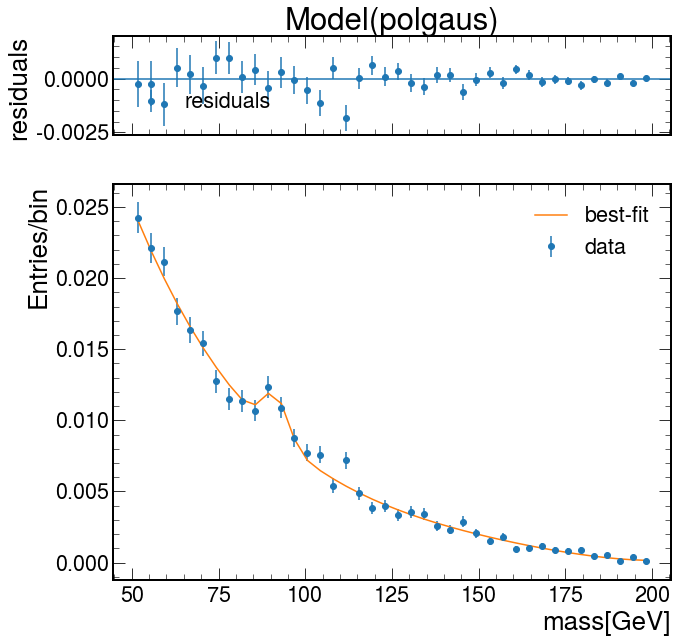

In [8]:
# Now we get the data histogram so we can fit it
# using a gaussian on top of 5th order polynomial
def polgaus(x, p0, p1, p2, p3,p4, a, mu, sigma):
    pols=[p0, p1, p2, p3, p4]
    poly  = np.polyval(pols,x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss
    return y

model = lm.Model(polgaus)
p = model.make_params(p0=-2.9898e-09,p1=2.0335e-06,p2=-4.6726e-04,
                      p3=0.03619398,p4=-.01,p5=.01,
                      a=1,b=-0.00188134,
                      lambd=1,mu=92,sigma=2.5)
result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())

In [9]:
mZ = result.params["mu"].value
mZerr = result.params["mu"].stderr

# W fit

In [10]:
def selectionW(iData):
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
    rho = np.log(iData.arrays('vjet0_msd0',library="np")["vjet0_msd0"]**2/iData.arrays('vjet0_pt',library="np")["vjet0_pt"])
    t21 = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"]/
           iData.arrays('vjet0_t1', library="np")["vjet0_t1"])
    t21ddt=t21+.065*rho
    t21cut   = t21ddt < .4
    allcuts = np.logical_and.reduce([trigger,jetpt, t21cut])
    return allcuts

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


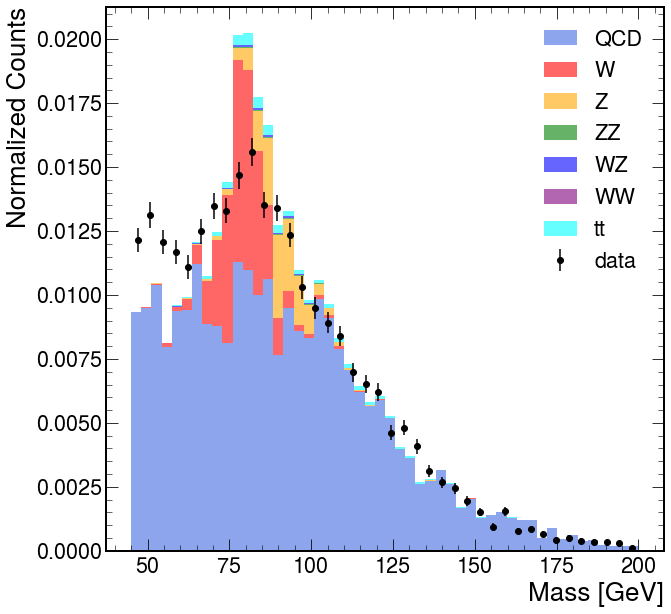

In [11]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
mrange = (45,200)
bins=40
density = True

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = selectionW(zqq13)
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = selectionW(ww)
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzW = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzW = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwW = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttW = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gghW = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

plt.hist([qcdW,wW, zW, zzW, wzW, wwW, ttW], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan",], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt",], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)
counts, bins = np.histogram(dataW,bins=bins,range=mrange,density=density)
yerr = np.sqrt(counts) / np.sqrt(len(dataW)*np.diff(bins))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

In [12]:
# p0=-2.9898e-09,p1=2.0335e-06,p2=-4.6726e-04,
#                       p3=0.03619398,p4=-.01,p5=.01,
#                       a=1,b=-0.00188134,mu=82.2,
#                       lambd=1,sigma=2.5
# goodfit_params = result.params.valuesdict()
# for key in goodfit_params:
#     print(key,goodfit_params[key], sep="=",end=", ")
# p0=-2.9898e-09, p1=2.0335e-06, p2=-0.00046726, p3=0.03619398, p4=-0.01, p5=0.01, a=1, mu=82.2, sigma=2.5, 

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 109
    # data points      = 28
    # variables        = 9
    chi-square         = 30.141556
    reduced chi-square = 1.58639767
    Akaike info crit   = 20.0636084
    Bayesian info crit = 32.0534490
[[Variables]]
    p0:    -2.6447e-12 +/- 2.5050e-13 (9.47%) (init = -3.343897e-12)
    p1:     1.6347e-09 +/- 1.8043e-10 (11.04%) (init = 2.133232e-09)
    p2:    -3.7572e-07 +/- 5.1325e-08 (13.66%) (init = -5.133544e-07)
    p3:     3.9577e-05 +/- 7.0898e-06 (17.91%) (init = 5.776477e-05)
    p4:    -0.00198305 +/- 4.6306e-04 (23.35%) (init = -0.003111808)
    p5:     0.05006621 +/- 0.01090406 (21.78%) (init = 0.07536875)
    a:      0.00430401 +/- 5.9544e-04 (13.83%) (init = 0.005048661)
    mu:     82.5682833 +/- 1.07193509 (1.30%) (init = 80)
    sigma:  9.87903348 +/- 1.52622183 (15.45%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p4, p5)    =

30.141556

<Figure size 720x720 with 0 Axes>

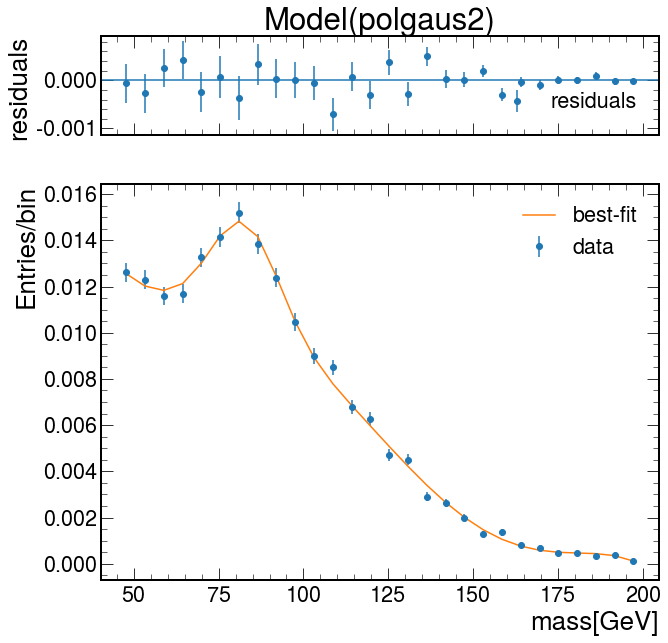

In [13]:
def polgaus2(x, p0, p1, p2, p3,p4,p5, a, mu, sigma):
    pols=[p0, p1, p2, p3, p4, p5]
    poly  = np.polyval(pols,x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss
    return y

bins=28
counts, bins = np.histogram(dataW,bins=bins,range=mrange, density=True)
yvar = counts/len(dataW)/np.diff(bins)
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12, p1=2.1332319456288657e-09, p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05, p4=-0.0031118077091850833, p5=0.07536875031296641, 
                      a=0.005048661046674717,mu=80, sigma=11.701217273469597, )

result = model.fit(data=y, params=p, x=x, weights=w, method="leastsq")
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
result.chisqr

In [14]:
mW = result.params["mu"].value
mWerr = result.params["mu"].stderr

we have that $\sin^2\theta_w = 1 - (\frac{m_W}{m_Z})^2$ which was measured to be about 0.231. Using the masses we measured and propagating the error gives 

In [15]:
sin2theta = 1 - (mW/mZ)**2
sin2theta_err = np.sqrt((2*mW*mWerr/mZ**2)**2 + (2*mW**2*mZerr/mZ**3)**2)
print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

sin^2(θ) = 0.184 +\- 0.029


Hmm... It looks like our measurement is pretty bad.  The reason for this is that we overestimated the mass of the W boson because many of the "signal" events selected contain a Z boson which has higher mass. Because we can't easily find a selection that removes Z jets and keeps W jets we will resort to making a correction from the Monte Carlo (MC.) Since we have control over what samples go into the MC we can actually do our fit with and without Z jets to see how biased our procedure is. Then we can correct for this bias approriatly.

# Correcting m_W

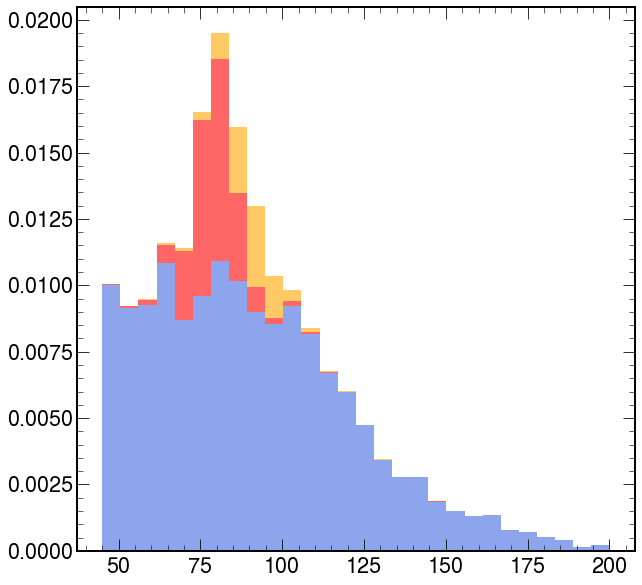

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 28
    # variables        = 9
    chi-square         = 124.38043
    reduced chi-square = 6.54633853
    Akaike info crit   = 59.7519301
    Bayesian info crit = 71.7417707
[[Variables]]
    p0:    -1.0797e-12 +/- 8.9062e-13 (82.49%) (init = -3.343897e-12)
    p1:     5.5236e-10 +/- 5.9768e-10 (108.20%) (init = 2.133232e-09)
    p2:    -8.5409e-08 +/- 1.5501e-07 (181.49%) (init = -5.133544e-07)
    p3:     1.9553e-06 +/- 1.9280e-05 (986.04%) (init = 5.776477e-05)
    p4:     3.6473e-04 +/- 0.00113797 (312.00%) (init = -0.003111808)
    p5:    -0.00623482 +/- 0.02497472 (400.57%) (init = 0.07536875)
    a:      0.00821996 +/- 0.00109256 (13.29%) (init = 0.005048661)
    mu:     82.1582678 +/- 0.89977402 (1.10%) (init = 80)
    sigma:  6.67924531 +/- 1.07203902 (16.05%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1

<Figure size 720x720 with 0 Axes>

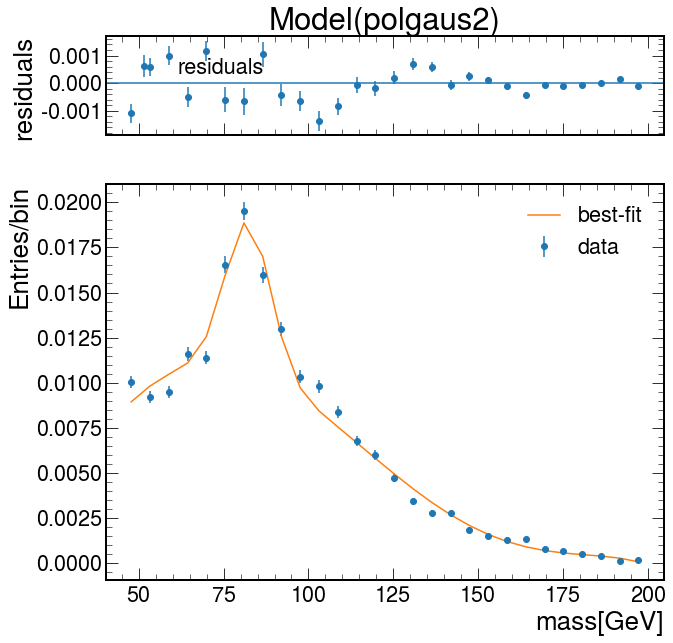

In [16]:
bins=28
# We need the weights from our MC
qcdweights = get_weights(qcd,weights,qcdsel)
wweights =get_weights(wqq13,weights,wsel)*wscale
zweights =get_weights(zqq13,weights,zsel)*zscale
# Now we stack the histograms into a single density 
# so we can fit bkg+signal
counts_mc, bins,_ = plt.hist([qcdW,wW,zW],bins=bins,range=mrange, density=True, stacked=True,
                             color=["royalblue","r", "orange"], alpha=.6,
                             weights=[qcdweights,wweights, zweights])
plt.show()

total_weights = sum([sum(weights) for weights in [qcdweights,wweights, zweights]])
counts = counts_mc[-1] #-1 gets the last stack of hists i.e. the total histogram
yvar = counts_mc[-1]/total_weights/np.diff(bins) # we normalize as usual
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12, p1=2.1332319456288657e-09, p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05, p4=-0.0031118077091850833, p5=0.07536875031296641, 
                      a=0.005048661046674717,mu=80, sigma=11.701217273469597, )
result = model.fit(data=y, params=p, x=x, weights=w, method="leastsq")
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
mW_mc_withZ = result.params["mu"].value
mWerr_mc_withZ = result.params["mu"].stderr

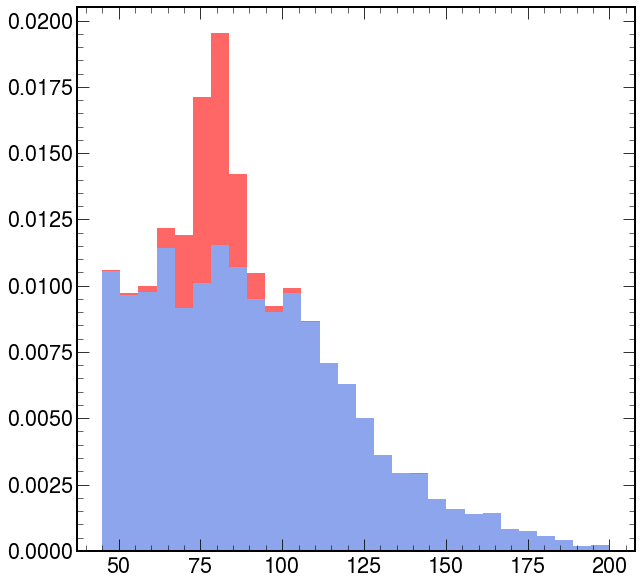

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 28
    # variables        = 9
    chi-square         = 97.99948
    reduced chi-square = 5.15786743
    Akaike info crit   = 53.0772149
    Bayesian info crit = 65.0670555
[[Variables]]
    p0:    -5.8737e-13 +/- 1.1401e-13 (19.41%) (init = -3.343897e-12)
    p1:     2.2405e-10 +/- 4.2203e-11 (18.84%) (init = 2.133232e-09)
    p2:    -1.2005e-09 +/- 4.3626e-09 (363.41%) (init = -5.133544e-07)
    p3:    -8.3150e-06 +/- 1.4631e-06 (17.60%) (init = 5.776477e-05)
    p4:     9.4750e-04 +/- 1.6511e-04 (17.43%) (init = -0.003111808)
    p5:    -0.01782877 +/- 0.00528899 (29.67%) (init = 0.07536875)
    a:      0.00859190 +/- 0.00114622 (13.34%) (init = 0.005048661)
    mu:     80.0963164 +/- 0.63987302 (0.80%) (init = 80)
    sigma:  4.58573091 +/- 0.66991295 (14.61%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p4, p5)    

<Figure size 720x720 with 0 Axes>

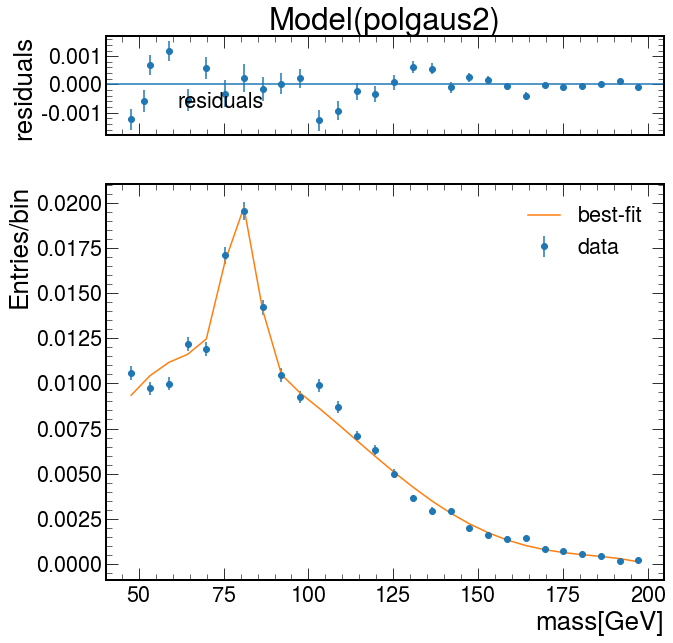

In [17]:
bins=28
# We need the weights from our MC
qcdweights = get_weights(qcd,weights,qcdsel)
wweights =get_weights(wqq13,weights,wsel)*wscale
# Now we stack the histograms into a single density 
# so we can fit bkg+signal
counts_mc, bins,_ = plt.hist([qcdW,wW],bins=bins,range=mrange, density=True, stacked=True,
                             color=["royalblue","r"], alpha=.6,
                             weights=[qcdweights,wweights])
plt.show()

total_weights = sum([sum(weights) for weights in [qcdweights,wweights]])
counts = counts_mc[-1] #-1 gets the last stack of hists i.e. the total histogram
yvar = counts_mc[-1]/total_weights/np.diff(bins) # we normalize as usual
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12, p1=2.1332319456288657e-09, p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05, p4=-0.0031118077091850833, p5=0.07536875031296641, 
                      a=0.005048661046674717,mu=80, sigma=11.701217273469597, )
result = model.fit(data=y, params=p, x=x, weights=w, method="leastsq")
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
mW_mc_noZ = result.params["mu"].value
mWerr_mc_noZ = result.params["mu"].stderr

In [18]:
# now we calculate our bias factor
# if the W mass measured with and without Z is the same 
# this factor should be 1
bias = mW_mc_withZ / mW_mc_noZ
#propagate the error assuming uncorellated gaussian uncertainties
bias_err = np.sqrt((mWerr_mc_noZ*mW_mc_withZ/mW_mc_noZ**2)**2+(mWerr_mc_withZ/mW_mc_noZ)**2)

In [19]:
mW_corrected = mW/bias
mWerr_corrected = np.sqrt((mWerr/bias)**2 + (bias_err*mW/bias**2)**2)

In [20]:
print(f"Correcting the W mass using MC (simulated data) gives m_W = {mW_corrected:.1f} +\- {mWerr_corrected:.1f}")

Correcting the W mass using MC (simulated data) gives m_W = 80.5 +\- 1.5


In [21]:
sin2theta = 1 - (mW_corrected/mZ)**2
sin2theta_err = np.sqrt((2*mW_corrected*mWerr_corrected/mZ**2)**2 + (2*mW_corrected**2*mZerr/mZ**3)**2)
print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

sin^2(θ) = 0.225 +\- 0.035


This measurement is much better than the previous one!